1\. **2D minimization of a six-hump camelback function**

$$f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2$$

has multiple global and local minima.

- Find the global minima of this function
- How many global minima are there, and what is the function value at those points?
- What happens for an initial guess of $(x, y) = (0, 0)$?

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use `numpy.meshgrid()` and `pylab.imshow()` to find visually the regions.
* Use `scipy.optimize.minimize()`, optionally trying its optional arguments.

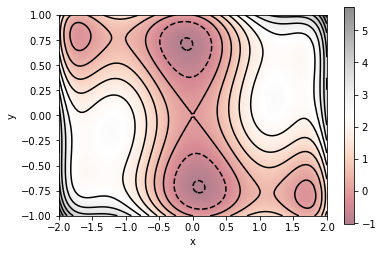

In [74]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from scipy import stats

def f(x):
    return (4 - 2.1*x[0]**2 + (1/3)*x[0]**4)*x[0]**2 + x[0]*x[1] + (4*x[1]**2 - 4)*x[1]**2

x = np.linspace(-2, 2, 100)
y = np.linspace(-1, 1, 100)
X, Y = np.meshgrid(x, y, sparse=True)
z = f((X, Y))

# nice article about density and contour plots:
# https://jakevdp.github.io/PythonDataScienceHandbook/04.04-density-and-contour-plots.html

plt.contour(x, y, z, 15, colors='black')
plt.imshow(z, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', cmap='RdGy', alpha=0.5, aspect=1.5)
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [75]:
# notes:
# scipy.optimize.root -> Find a root of a vector function
# scipy.optimize.minimize_scalar -> Minimization of scalar function of one variable
# scipy.optimize.minimize -> Minimization of scalar function of one or more variables

# find global minima
x0_guess = np.array([[0, 0.75], [0, -0.75]])
x0 = np.zeros(4).reshape(2,2)
value = np.zeros(2)

for i in range(0,2):   
    sol = optimize.minimize(f, x0_guess[i])
    if sol['success']:
        x0[i] = sol['x']
        value[i] = sol['fun'] 
        
print('global minima:', x0[0], 'and', x0[1])
print('function value:', value[0])

global minima: [-0.08984202  0.71265641] and [ 0.08984201 -0.71265642]
function value: -1.0316284534898768


In [76]:
# for an initial guess of (x, y) = (0, 0) the algorithm gets stuck in a (false) local minimum

sol = optimize.minimize(f, [0,0])
print(sol, '\n')

# check if (x, y) = (0, 0) is indeed a minimum by looking around it
x = [0.1, -0.1]
value = [f([i,j]) for i in x for j in x]
    
if any(f < sol['fun'] for f in value):
    print(sol['x'], 'is not a minimum')

      fun: 0.0
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([ 5.96046448e-08, -5.96046448e-08])
  message: 'Optimization terminated successfully.'
     nfev: 3
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([0., 0.]) 

[0. 0.] is not a minimum


2\. **Curve fitting of temperature in Alaska** 

The temperature extremes in Alaska for each month, starting in January, are given by (in degrees Celcius):

max:  `17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18`

min: `-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58`

* Plot these temperatures.
* Find a suitable a function that can describe min and max temperatures. 
* Fit this function to the data with `scipy.optimize.curve_fit()`.
* Plot the result. Is the fit reasonable? If not, why?
* Is the time offset for min and max temperatures the same within the fit accuracy?

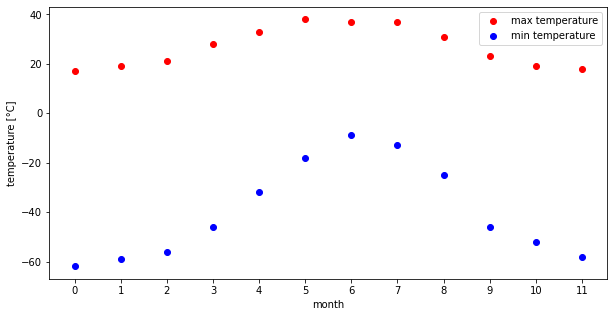

In [77]:
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

t_max = np.array((17, 19, 21, 28, 33, 38, 37, 37, 31, 23, 19, 18))
t_min = np.array((-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58))

fig, ax = plt.subplots(figsize=(10,5))
months = np.arange(12)
ax.plot(months, t_max, 'ro', label='max temperature')
ax.plot(months, t_min, 'bo', label='min temperature')
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.set_xlabel('month')
ax.set_ylabel('temperature [°C]')
ax.legend()
plt.show()


max temperature fit

A = 10.64 +- 0.41
B = -2.98 +- 0.07
C = 27.63 +- 0.30

min temperature fit

A = 25.21 +- 1.35
B = -3.40 +- 0.10
C = -37.71 +- 0.98


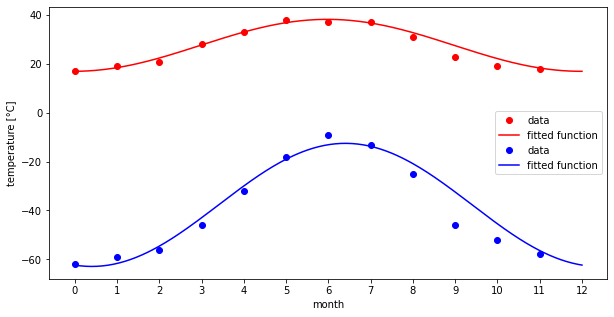

In [78]:
# fit using a sine funtcion
def sine(x, A, B, C):
    # fix the period T = 2*pi/nu
    nu = 2*np.pi/x.max()
    return A*np.sin((x + B)*nu) + C

popt_max, pcov_max = optimize.curve_fit(sine, months, t_max, p0=[10, 0, 30], full_output=False)
print('\nmax temperature fit\n')
print("A = %.2f +- %.2f" % (popt_max[0], np.sqrt(pcov_max[0,0])))
print("B = %.2f +- %.2f" % (popt_max[1], np.sqrt(pcov_max[1,1])))
print("C = %.2f +- %.2f" % (popt_max[2], np.sqrt(pcov_max[2,2])))

popt_min, pcov_min = optimize.curve_fit(sine, months, t_min, p0=[20, 0, -40], full_output=False)
print('\nmin temperature fit\n')
print("A = %.2f +- %.2f" % (popt_min[0], np.sqrt(pcov_min[0,0])))
print("B = %.2f +- %.2f" % (popt_min[1], np.sqrt(pcov_min[1,1])))
print("C = %.2f +- %.2f" % (popt_min[2], np.sqrt(pcov_min[2,2])))


fig, ax = plt.subplots(figsize=(10,5))

x = np.linspace(0, 12, 365)

# max temperature
ax.plot(months, t_max, 'ro', label='data')
ax.plot(x, sine(x, popt_max[0], popt_max[1], popt_max[2]), 'r', label='fitted function')
# min temperature
ax.plot(months, t_min, 'bo', label='data')
ax.plot(x, sine(x, popt_min[0], popt_min[1], popt_min[2]), 'b', label='fitted function')

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.set_xlabel('month')
ax.set_ylabel('temperature [°C]')
ax.legend()

plt.show()

In [79]:
# naive statistical compatibility
N = abs(popt_max[1] - popt_min[1])/np.sqrt(pcov_max[1,1] + pcov_min[1,1])
if N > 3:    
    print('time offsets for min and max temperatures are not compatible')
else:
    print('time offsets for min and max temperatures are compatible')

time offsets for min and max temperatures are not compatible


3\. **Fit the residues**

Read the `data/residuals_261.pkl` file. If you haven't it already, download it from here:

```bash
wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P data/
```

The feature name "residual" contains the residuals (defined as $y_i - \hat{y}_i$) of a linear regression as a function of the independent variable "distances".

- Considering only the "residual" feature, create an histogram with the appropriate binning and display it.
- Set the appropriate Poisson uncertainty for each bin (thus, for each bin, $\sigma_i = \sqrt{n_i}$, where $n_i$ is the number of entries in each bin)
- By looking at the distribution of the residuals, define an appropriate function and fit it to the histogram of the residuals
- Perform a goodness-of-fit test. Is the p-value of the fit satisfactory?

In [80]:
data = np.load('residuals_261.pkl', allow_pickle=True)[()]['residuals']
print(data.shape)

# filter the data
offset = -0.1 # estimation of the mean
d = 1 # fix max distance from the mean
nbin = 50
data = np.array([x for x in data if abs(x - offset) < d])
print(data.shape)

(11131,)
(9925,)


integral = 396.99999999997834
data mean = -0.09605697493102977
data std = 0.30213305389703665

gaussian fit

A = 364.81 +- 7.95
mu = -0.09 +- 0.01
sigma = 0.23 +- 0.01


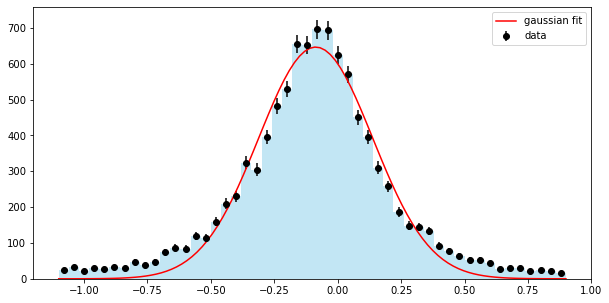

R2 = 0.9725708194684364 
R = 0.9861900524079709

degrees of freedom = 49
chi2 = 782.9505473039719
p-value = 0.0


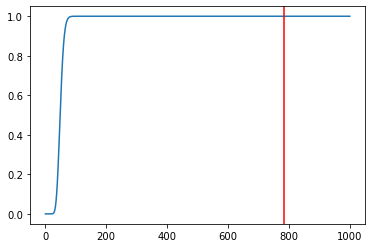

In [81]:
fig, ax = plt.subplots(figsize=(10,5))

# histogram
bin_counts, bin_edges, patches = ax.hist(data, bins=nbin, color='skyblue', alpha=0.5)
bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
ax.errorbar(bin_centers, bin_counts, yerr=np.sqrt(bin_counts), fmt='o', color='black', label='data')

# let's try first a simple gaussian fit
def gaussian(x, A, mu, sigma):
    return (A/np.sqrt(2*np.pi*sigma**2))*np.exp(-(x - mu)**2/(2*sigma**2))

# initial guesses
I = len(data)*(bin_edges[1]- bin_edges[0]) # integral of the histogram 
mu = data.mean()
sigma = data.std()

print('integral =',I)
print('data mean =', mu)
print('data std =', sigma)

popt, pcov = optimize.curve_fit(gaussian, bin_centers, bin_counts,
                                bounds=([0, -0.5, 0], [I, 0.5, 1]),
                                p0=[I, mu, sigma])
print('\ngaussian fit\n')
print("A = %.2f +- %.2f" % (popt[0], np.sqrt(pcov[0,0])))
print("mu = %.2f +- %.2f" % (popt[1], np.sqrt(pcov[1,1])))
print("sigma = %.2f +- %.2f" % (popt[2], np.sqrt(pcov[2,2])))

x = np.linspace(bin_edges[0], bin_edges[-1], 100)
ax.plot(x, gaussian(x, popt[0], popt[1], popt[2]), 'r', label='gaussian fit')
ax.legend()
plt.show()

# goodness-of-fit test
y = bin_counts
sigma_y = np.sqrt(bin_counts)
y_th = gaussian(bin_centers, popt[0], popt[1], popt[2])

# correlation coefficient
ssr = np.sum((y - y_th)**2)
tss = np.sum((np.mean(y) - y)**2)
rsq = 1 - ssr / tss
print("R2 =", rsq, "\nR =", np.sqrt(rsq))

# p-value
ndof = len(y) - 1
chi2 = np.sum((y - y_th)**2/sigma_y**2)
pvalue = 1. - stats.chi2.cdf(chi2, ndof)
print("\ndegrees of freedom =", ndof)
print("chi2 =", chi2)
print("p-value =", pvalue) # if the p-value is < 0.05, the fit is considered unsatisfactory

p = np.arange(0, 1000, 0.1)
plt.plot(p, stats.chi2.cdf(p, df=ndof))
plt.axvline(chi2, color='r')
plt.show()


two gaussian fit

A1 = 239.47 +- 18.57
mu1 = -0.08 +- 0.00
sigma1 = 0.17 +- 0.01

A2 = 158.80 +- 17.15
mu2 = -0.13 +- 0.02
sigma2 = 0.47 +- 0.05


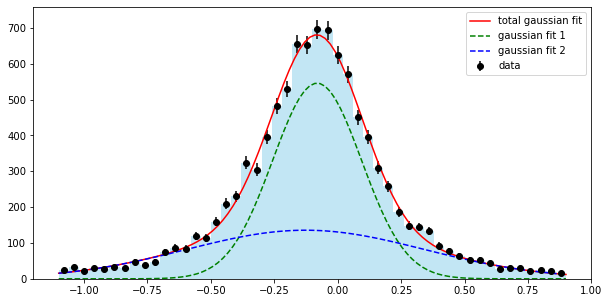

R2 = 0.993745864792491 
R = 0.9968680277712246

degrees of freedom = 49
chi2 = 80.0185091438677
p-value = 0.0033873496061308517


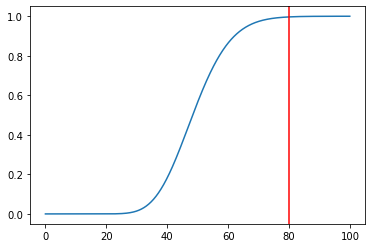

In [82]:
fig, ax = plt.subplots(figsize=(10,5))

# histogram
bin_counts, bin_edges, patches = ax.hist(data, bins=nbin, color='skyblue', alpha=0.5)
bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
ax.errorbar(bin_centers, bin_counts, yerr=np.sqrt(bin_counts), fmt='o', color='black', label='data')

# let's try with a two gaussian fit
def two_gaussian(x, A1, mu1, sigma1, A2, mu2, sigma2):
    g1 = (A1/np.sqrt(2*np.pi*sigma1**2))*np.exp(-(x - mu1)**2/(2*sigma1**2))
    g2 = (A2/np.sqrt(2*np.pi*sigma2**2))*np.exp(-(x - mu2)**2/(2*sigma2**2))
    return g1 + g2

popt, pcov = optimize.curve_fit(two_gaussian, bin_centers, bin_counts,
                                bounds=([0, -0.5, 0, 0, -0.5, 0], [I, 0.5, 1, 0.4*I, 0.5, 2]),
                                p0=[0.8*I, mu, 0.5*sigma, 0.2*I, mu, 2*sigma])
print('\ntwo gaussian fit\n')
print("A1 = %.2f +- %.2f" % (popt[0], np.sqrt(pcov[0,0])))
print("mu1 = %.2f +- %.2f" % (popt[1], np.sqrt(pcov[1,1])))
print("sigma1 = %.2f +- %.2f" % (popt[2], np.sqrt(pcov[2,2])))
print("\nA2 = %.2f +- %.2f" % (popt[3], np.sqrt(pcov[3,3])))
print("mu2 = %.2f +- %.2f" % (popt[4], np.sqrt(pcov[4,4])))
print("sigma2 = %.2f +- %.2f" % (popt[5], np.sqrt(pcov[5,5])))

x = np.linspace(bin_edges[0], bin_edges[-1], 100)
ax.plot(x, two_gaussian(x, popt[0], popt[1], popt[2], popt[3], popt[4], popt[5]), 'r', label='total gaussian fit')
ax.plot(x, gaussian(x, popt[0], popt[1], popt[2]), '--g', label='gaussian fit 1')
ax.plot(x, gaussian(x, popt[3], popt[4], popt[5]), '--b', label='gaussian fit 2')
ax.legend()
plt.show()

# goodness-of-fit test
y = bin_counts
sigma_y = np.sqrt(bin_counts)
y_th = two_gaussian(bin_centers, popt[0], popt[1], popt[2], popt[3], popt[4], popt[5])

# correlation coefficient
ssr = np.sum((y - y_th)**2)
tss = np.sum((np.mean(y) - y)**2)
rsq = 1 - ssr/tss
print("R2 =", rsq, "\nR =", np.sqrt(rsq))

# p-value
ndof = len(y) - 1
chi2 = np.sum((y - y_th)**2/sigma_y**2)
pvalue = 1. - stats.chi2.cdf(chi2, ndof)
print("\ndegrees of freedom =", ndof)
print("chi2 =", chi2)
print("p-value =", pvalue) # if the p-value is < 0.05, the fit is considered unsatisfactory

p = np.arange(0, 100, 0.1)
plt.plot(p, stats.chi2.cdf(p, df=ndof))
plt.axvline(chi2, color='r')
plt.show()

4\. **Temperatures in Munich**

Get the following data file:

```bash
https://www.dropbox.com/s/7gy9yjl00ymxb8h/munich_temperatures_average_with_bad_data.txt
```

which gives the temperature in Munich every day for several years.


Fit the following function to the data:

$$f(t) = a \cos(2\pi t + b)+c$$

where $t$ is the time in years.

- Make a plot of the data and the best-fit model in the range 2008 to 2012.

   - What are the best-fit values of the parameters?

   - What is the overall average temperature in Munich, and what are the typical daily average values predicted by the model for the coldest and hottest time of year?

   - What is the meaning of the $b$ parameter, and what physical sense does it have?


- Now fit the data with the function $g(x)$, which has 1 more parameter than $f(x)$.
$$g(x) = a \cos(2\pi b t + c)+d$$
   - What are the RSS for $f(x)$ and $g(x)$?
   - Use the Fisher F-test to determine whether the additional parameter is necessary.

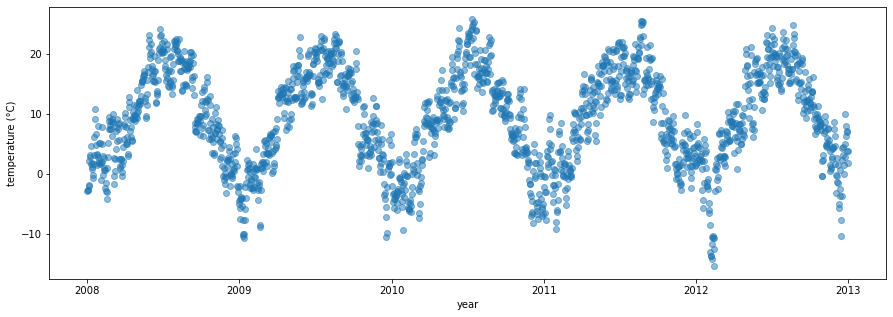

In [83]:
file_name = 'munich_temperatures_average_with_bad_data.txt'

data = np.loadtxt(file_name)
# select range 2008 to 2013
data = data[(data[:,0] > 2008) & (data[:,0] < 2013)]
# get rid of bad data
data = data[data[:,1] < 40]

fig, ax = plt.subplots(figsize=(15,5))
ax.scatter(data[:,0], data[:,1], label='data', alpha=0.5)
ax.set_xlabel('year')
ax.set_ylabel('temperature (°C)')
plt.show()

it with 3 parameters

a = -10.00 +- 0.12
b = -0.24 +- 0.01
c = 9.25 +- 0.09


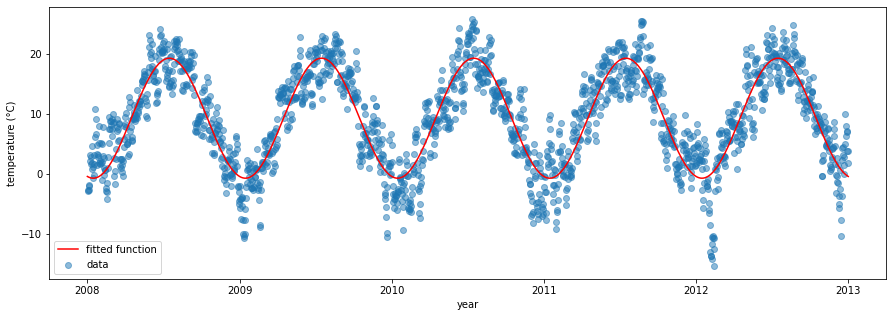

In [102]:
def f(t, a, b, c):
    return a*np.cos(2*np.pi*t + b) + c

popt, pcov = optimize.curve_fit(f, data[:,0], data[:,1], p0=[10, 0, 10])
print('\fit with 3 parameters\n')
print("a = %.2f +- %.2f" % (popt[0], np.sqrt(pcov[0,0])))
print("b = %.2f +- %.2f" % (popt[1], np.sqrt(pcov[1,1])))
print("c = %.2f +- %.2f" % (popt[2], np.sqrt(pcov[2,2])))

fig, ax = plt.subplots(figsize=(15,5))
# data
ax.scatter(data[:,0], data[:,1], label='data', alpha=0.5)
ax.set_xlabel('year')
ax.set_ylabel('temperature (°C)')
# fitted function
x = np.linspace(2008, 2013, 1000)
ax.plot(x, f(x, popt[0], popt[1], popt[2]), 'r', label='fitted function')
ax.legend()
plt.show()

In [103]:
print('overall average temperature in Munich: %.2f °C' % popt[2])
print('predicted daily average value for the coldest period of the year: %.2f °C' % (popt[0] + popt[2]))
print('predicted daily average value for the hottest period of the year: %.2f °C' % (-popt[0] + popt[2]))

# Parameter b represents a shift of the cosine function with respect to the coordinate t.
# From a physics point of view it tells us after how long from the beginning of the year
# the coldest period arrives (since parameter a is negative).

overall average temperature in Munich: 9.25 °C
predicted daily average value for the coldest period of the year: -0.74 °C
predicted daily average value for the hottest period of the year: 19.25 °C



fit with 4 parameters

a = -10.00 +- 0.12
b = 1.00 +- 0.00
c = 11.76 +- 17.24
d = 9.24 +- 0.09


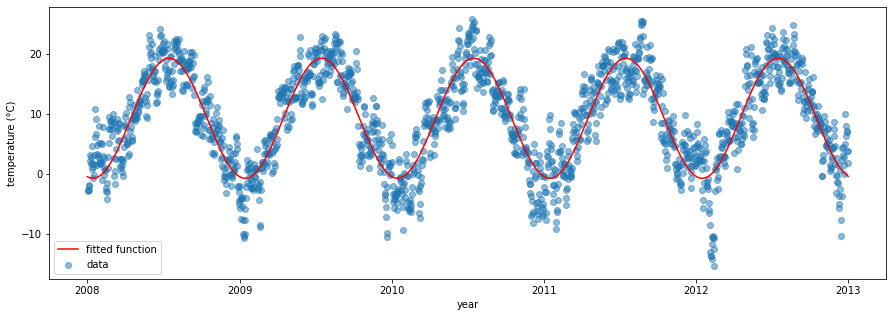

In [104]:
def g(t, a, b, c, d):
    return a*np.cos(2*np.pi*b*t + c) + d

popt, pcov = optimize.curve_fit(g, data[:,0], data[:,1], p0=[10, 1, 0, 10])
print('\nfit with 4 parameters\n')
print("a = %.2f +- %.2f" % (popt[0], np.sqrt(pcov[0,0])))
print("b = %.2f +- %.2f" % (popt[1], np.sqrt(pcov[1,1])))
print("c = %.2f +- %.2f" % (popt[2], np.sqrt(pcov[2,2])))
print("d = %.2f +- %.2f" % (popt[3], np.sqrt(pcov[3,3])))

fig, ax = plt.subplots(figsize=(15,5))
# data
ax.scatter(data[:,0], data[:,1], label='data', alpha=0.5)
ax.set_xlabel('year')
ax.set_ylabel('temperature (°C)')
# fitted function
x = np.linspace(2008, 2013, 1000)
ax.plot(x, g(x, popt[0], popt[1], popt[2], popt[3]), 'r', label='fitted function')
ax.legend()
plt.show()

In [106]:
y = data[:, 1]
y_th_1 = f(data[:, 0], popt[0], popt[1], popt[2])
y_th_2 = g(data[:, 0], popt[0], popt[1], popt[2], popt[3])

# sum of squared residuals
ssr_1 = np.sum((y - y_th_1)**2)
ndof_1 = 2 # n of parameters - 1
ssr_2 = np.sum((y - y_th_2)**2)
ndof_2 = 3 # n of parameters - 1

print('RSS for fit with 3 paameters:', int(ssr_1))
print('RSS for fit with 4 paameters:', int(ssr_2))

RSS for fit with 3 paameters: 159371
RSS for fit with 4 paameters: 24672


In [107]:
# define function for F-test
def Ftest(ssr_1, ssr_2, ndof_1, ndof_2, nbins, verbose=False):
    F = ((ssr_1 - ssr_2)/(ndof_2 - ndof_1)) / (ssr_2/(nbins - ndof_2))
    CL = 1. - stats.f.cdf(F, ndof_2 - ndof_1, nbins - ndof_2)
    if verbose: print("CL: %.3f" % CL, ", additional parameter necessary:", "YES" if CL < 0.10 else "NO")
    return CL

print("Test 3 vs 4 fitting parameters:")
cl_3_vs_4 = Ftest(ssr_1, ssr_2, ndof_1, ndof_2, data.shape[0], verbose=True)

Test 3 vs 4 fitting parameters:
CL: 0.000 , additional parameter necessary: YES
